In [6]:
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor

from torch.utils.data import DataLoader
from typing import Mapping

from miniai.training import *
from miniai.datasets import *
     

mpl.rcParams['image.cmap'] = 'gray'

In [3]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [4]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)
     

mpl.rcParams['figure.dpi'] = 30
     

<Axes: >

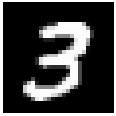

In [13]:
im3 = x_imgs[7]
show_image(im3)

In [17]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0 ,0],
                   [ 1 ,1 ,1]]).float()

<Axes: >

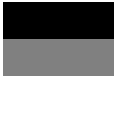

In [18]:
show_image(top_edge)

In [19]:
df = pd.DataFrame(im3[:13,:23])
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [26]:
(im3[3:6,14:17]*top_edge).sum()

tensor(2.9727)

tensor(-0.0234)

In [32]:
def apply_kernel(im, kernel): 
    r,c = im.shape
    imgkern = torch.zeros(r,c)
    for i in range(1,r-1):
        for j in range(1,c-1):
            imgkern[i,j] = (im[i-1:i+1][j-1:j+1]*kernel).sum()
    return imgkern

In [35]:
test = apply_kernel(im3, top_edge)
show_image(test)

RuntimeError: The size of tensor a (28) must match the size of tensor b (3) at non-singleton dimension 1